# [07] Sklearn SVC Testing (calc or no-calc)
Similar to "[06] Log Loss SGD Training (Concat, calcification)" we are using a scikit model but this time using a Support Vector Classifier (SVC). We are again running on the concat images set with testing between calcification or not. In this notebook we also test the quality of the classifier when inputting different numbers of eigenvectors to see the potential impact.

This time I used a tutorial from (link) to learn how to use SVC but I didn't use much of their code:

https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

and still use mostly the same confusion matrix function from

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

Code from tutorial is marked as such


In [1]:
## Utilizing tutorial from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
## Code used from tutorial will be marked as such

%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pickle
import random
import math as m
import time
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
## loading in important variables

# Eigenvectors
with open('train_concat_vectors.npy', 'rb') as f:
    train_concat_vectors = pickle.load(f) 
vectors = train_concat_vectors

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Images
with open('concat_imgs.npy', 'rb') as f:
    concat_imgs = pickle.load(f) 
scale = (162, 135)

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

# Abnormalities
with open('abnormalities.pkl', 'rb') as f:
    abnormalities = pickle.load(f)
abnorms = []
for i in range(2575):
    if abnormalities[2*i] != abnormalities[2*i+1]:
        print("abnormalities not equal")
    abnorms.append(abnormalities[2*i])
abnorms = np.array(abnorms)

Wall time: 1min 45s


In [6]:
## Takes flattened images (wxh, n), eigenvectors for the set, and k = new dimensionality
## Returns an array similar to flattened images array but with k instead of n dimensions
def reduce_dimensionality(imgs, vecs, k):
    reduced_dim = np.matmul(vecs[:k], imgs)
    return reduced_dim

## Converts the reduced dimension scan back to original image dimension
def reduced_to_img(reduced, vecs):
    approx = np.matmul(vecs[:reduced.shape[0]].T, reduced)
    return approx

## Combined the above two functions for convenience in creating downscaled images
def reduce_img_dim(imgs, vecs, k):
    return reduced_to_img(reduce_dimensionality(imgs, vecs, k), vecs)

In [123]:
## Setting inputs (full concat set) and labels
inputs = concat_imgs
labels = []
for i in range(abnorms.shape[0]):
    if abnorms[i] == "calcification"  or abnorms[i] == "both":
        labels.append(1)
    else:
        labels.append(0)
labels = np.array(labels)

In [139]:
## Setting train/test/validation sets
# helper function to set train/test/validation sets for inputs
def set_inputs(new_inputs):
    X_train = new_inputs[train_set]
    X_test = new_inputs[test_set]
    X_validation = new_inputs[validation_set]
    return
set_inputs(inputs)
y_train = labels[train_set]
y_test = labels[test_set]
y_validation = labels[validation_set]

In [262]:
## Creating a set from test and validation that consists of 50/50 positives and negatives for testing
set_5050 = []
count = 0
for i in range(test_set.shape[0]):
    if y_test[i] == 1:
        set_5050.append(test_set[i])
    else:
        if count<146:
            set_5050.append(test_set[i])
            count+=1
for i in range(validation_set.shape[0]):
    if y_validation[i] == 1:
        set_5050.append(validation_set[i])
    else:
        if count<146:
            set_5050.append(validation_set[i])
            count+=1
set_5050 = np.array(set_5050)
print(set_5050.shape)

(292,)


In [263]:
## Creating test sets with 50/50 splits
X_set_5050 = []
y_set_5050 = []
count = 0
for i in range(test_set.shape[0]):
    if y_test[i] == 1:
        X_set_5050.append(X_test[i])
        y_set_5050.append(y_test[i])
    else:
        if count<146:
            X_set_5050.append(X_test[i])
            y_set_5050.append(y_test[i])
            count+=1
for i in range(validation_set.shape[0]):
    if y_validation[i] == 1:
        X_set_5050.append(X_validation[i])
        y_set_5050.append(y_validation[i])
    else:
        if count<146:
            X_set_5050.append(X_validation[i])
            y_set_5050.append(y_validation[i])
            count+=1
X_set_5050 = np.array(X_set_5050)
y_set_5050 = np.array(y_set_5050)
print(X_set_5050.shape)
print(y_set_5050.shape)

(292, 43740)
(292,)


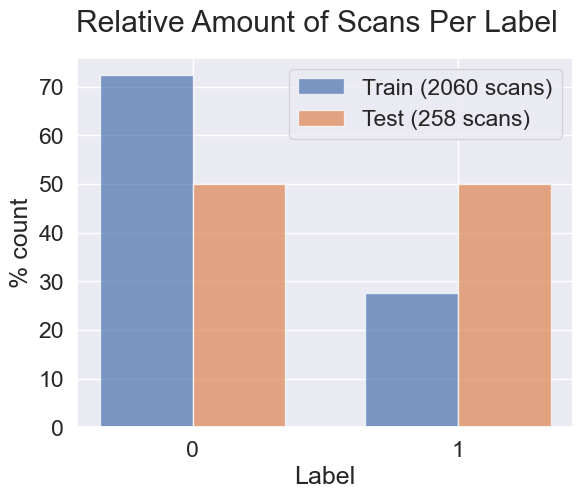

In [270]:
### TUTORIAL CODE ###
## Plotting the distribution of data
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('Label')
    plt.ylabel(ylabel_text)
 
plt.suptitle('Relative Amount of Scans Per Label')
plot_bar(y_train, loc='left')
plot_bar(y_set_5050, loc='right')
plt.legend([
    'Train ({0} scans)'.format(len(y_train)), 
    'Test ({0} scans)'.format(len(y_test))
]);

In [293]:
##  Function to train models using different weights in order to compare the accuracies of those different weights
def test_weights(X_train, y_train, X_test, y_test, zero_weights, plot_accuracies=False):
    accuracies = []
    models = []
    for i in range(len(zero_weights)):
        w = zero_weights[i]
        print(f"Testing weight: {w}")
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight={0: w, 1: 1-w}))
        models.append(clf)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracies.append(accuracy(predictions, y_test))
        print(f"Accuracy of [0: {w}, 1: {1-w}] = {accuracies[i]}")
        mat = confusion_matrix(y_test, predictions)
        print(f"Correct 0: {mat[0][0]}, Correct 1: {mat[1][1]}")
        print(f"False 0: {mat[1][0]}, False 1: {mat[0][1]}")
        print(f"Guessed positive at rate: {(mat[0][1]+mat[1][1])/y_test.shape[0]}, Real rate: {(mat[1][0]+mat[1][1])/y_test.shape[0]}")
        print()
    if plot_accuracies:
        fig, ax = plt.subplots()
        ax.plot(zero_weights,accuracies)
        ax.ticklabel_format(useOffset=False)
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)
        plt.show()
    return accuracies, models

In [291]:
## Function to make a plot of a variety of stats based on the weights applied when training a set of models
# accuracies:       raw accuracy of model
# selection_rates:  percent of predictions where the model predicts 1
# true_rates:       percent of actual instances of 1 in the dataset
# accuracy_on_1:    percent of correct 1 predictions out of all 1 predictions
# accuracy_on_0:    percent of correct 0 predictions out of all 0 predictions
# round_weights:    weights used to train the model rounded to account for instances like 0.2799999999999 from np.arange()
def plot_rates(y, predictions, weights, height=1.5):
    mats = []
    accuracies = []
    selection_rates = []
    true_rates = []
    round_weights = []
    accuracy_on_1 = []
    accuracy_on_0 = []
    for i in range(len(predictions)):
        round_weights.append(round(weights[i], 2))
        mat = confusion_matrix(y, predictions[i])
        mats.append(mat)
        accuracies.append((mat[0][0]+mat[1][1])/y.shape[0])
        selection_rates.append((mat[0][1]+mat[1][1])/y.shape[0])
        true_rates.append((mat[1][0]+mat[1][1])/y.shape[0])
        accuracy_on_1.append(mat[1][1]/(mat[1][0]+mat[1][1]))
        accuracy_on_0.append(mat[0][0]/(mat[0][0]+mat[0][1]))
    plt.plot(round_weights, accuracies, label = "Accuracy")
    plt.plot(round_weights, selection_rates, label = "Positive Selection Rate")
    plt.plot(round_weights, true_rates, label = "True Positive Rate")
    plt.plot(round_weights, accuracy_on_1, label = "Accuracy on Positives")
    plt.plot(round_weights, accuracy_on_0, label = "Accuracy on Negatives")
    plt.ylabel("Percentages")
    plt.xlabel("Weights for 0")
    plt.title("Accuracy and Selection Rates of Differently Weighted Models")
    plt.ylim(0, height)
    plt.legend()
    plt.show()

In [29]:
## Function to test the percent correct a model is
def accuracy(predicted, actual):
    count = 0
    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            count+=1
    return count/len(predicted)

In [155]:
### (mostly) from https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/ ###
# Function to create a confusion matrix (function from tutorial with slight modification)
from sklearn.metrics import confusion_matrix
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")

In [159]:
%%time
## Testing training a model
w = 0.275
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight={0: w, 1: 1-w}))
clf.fit(X_train, y_train)

Wall time: 47.2 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight={0: 0.3, 1: 0.7}, gamma='auto'))])

In [160]:
%%time
## Viewing model predictions
predictions = clf.predict(X_test)
print(predictions)
#print(y_test)
accuracy(predictions, y_test)

[0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1
 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1
 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1
 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0]
Wall time: 17.3 s


0.6201550387596899

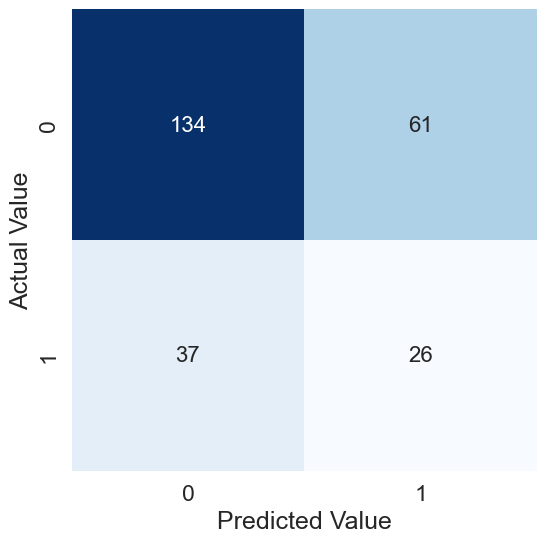

In [161]:
## Viewing model confusion matrix
conf_matrix(labels[test_set], predictions)

In [208]:
%%time
## Testing models across weights (long runtime ~11mins)
accuracies, models = test_weights(X_train, y_train, X_test, y_test, np.arange(0.25, 0.35, 0.01), plot_accuracies=True)

Wall time: 0 ns


In [178]:
## Function to create list of predictions from multiple models
def get_predictions(X_test,models):
    predictions = []
    for i in range(len(models)):
        pred = models[i].predict(X_test)
        predictions.append(pred)
    return predictions

In [224]:
%%time
## Get the predictions on the test set from the model trained above (runtime ~3mins)
predictions_5050 = get_predictions(X_set_5050, models)

Wall time: 3min 18s


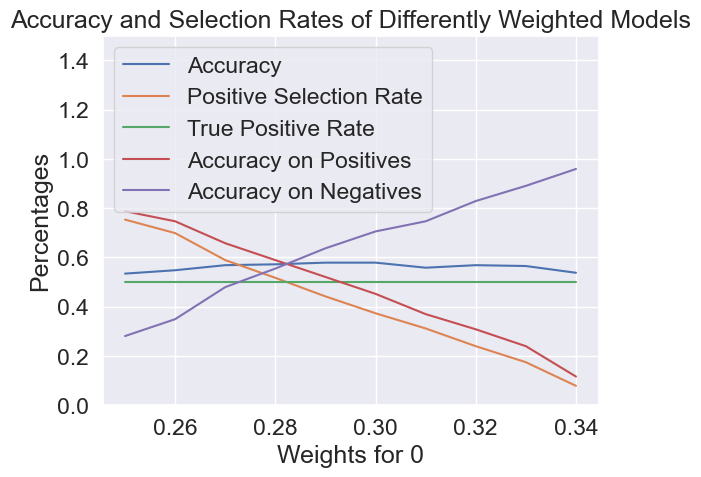

In [229]:
## Plot data from the models trained above
plot_rates(y_set_5050, predictions_5050, np.arange(0.25, 0.35, 0.01))

In [255]:
## Function to train the classifier with inputs consisting of different numbers of eigenvectors
def train_by_eigenvectors(inputs, labels, zero_weight, num_vectors, include_full=True, plot_accuracies=False, vectors=vectors, train_set=train_set, test_set=test_set):
    accuracies = []
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight={0: zero_weight, 1: 1-zero_weight}))
    y_train, y_test = labels[train_set], labels[test_set]
    for i in range(len(num_vectors)):
        print(f"Training with {num_vectors[i]} Eigenvectors")
        scans = reduce_dimensionality(concat_imgs.T, vectors, num_vectors[i]).T
        X_train, X_test = scans[train_set], scans[test_set]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracies.append(accuracy(predictions, y_test))
        print(f"Accuracy with {num_vectors[i]} dims = {accuracies[i]}")
        mat = confusion_matrix(y_test, predictions)
        print(f"Correct 0: {mat[0][0]}, Correct 1: {mat[1][1]}")
        print(f"False 0: {mat[1][0]}, False 1: {mat[0][1]}")
        print(f"Guessed positive at rate: {(mat[0][1]+mat[1][1])/y_test.shape[0]}, Real rate: {(mat[1][0]+mat[1][1])/y_test.shape[0]}")
        print()
    if include_full:
        X_train, X_test = concat_imgs[train_set], concat_imgs[test_set]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        full_accuracy = accuracy(predictions, y_test)
        print(f"Accuracy with Full Images = {full_accuracy}")
        mat = confusion_matrix(y_test, predictions)
        print(f"Correct 0: {mat[0][0]}, Correct 1: {mat[1][1]}")
        print(f"False 0: {mat[1][0]}, False 1: {mat[0][1]}")
        print(f"Guessed positive at rate: {(mat[0][1]+mat[1][1])/y_test.shape[0]}, Real rate: {(mat[1][0]+mat[1][1])/y_test.shape[0]}")
    if plot_accuracies:
        fig, ax = plt.subplots()
        ax.plot(num_vectors,accuracies, color='b', label='Accuracy')
        if include_full: ax.hlines(y=full_accuracy, xmin=num_vectors[0], xmax=num_vectors[-1], linewidth=2, color='r', label='Full Image Accuracy')
        ax.ticklabel_format(useOffset=False)
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)
        ax.set_title("Number of Eigenvectors vs Accuracy of Model")
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Number of Eigenvectors")
        #ax.set_ylim(0, 1)
        ax.legend()
        plt.show()
    return accuracies, full_accuracy

Training with 1 Eigenvectors
Accuracy with 1 dims = 0.4965753424657534
Correct 0: 50, Correct 1: 95
False 0: 51, False 1: 96
Guessed positive at rate: 0.6541095890410958, Real rate: 0.5

Training with 5 Eigenvectors
Accuracy with 5 dims = 0.5273972602739726
Correct 0: 68, Correct 1: 86
False 0: 60, False 1: 78
Guessed positive at rate: 0.5616438356164384, Real rate: 0.5

Training with 10 Eigenvectors
Accuracy with 10 dims = 0.589041095890411
Correct 0: 91, Correct 1: 81
False 0: 65, False 1: 55
Guessed positive at rate: 0.4657534246575342, Real rate: 0.5

Training with 15 Eigenvectors
Accuracy with 15 dims = 0.589041095890411
Correct 0: 95, Correct 1: 77
False 0: 69, False 1: 51
Guessed positive at rate: 0.4383561643835616, Real rate: 0.5

Training with 20 Eigenvectors
Accuracy with 20 dims = 0.571917808219178
Correct 0: 92, Correct 1: 75
False 0: 71, False 1: 54
Guessed positive at rate: 0.4417808219178082, Real rate: 0.5

Training with 25 Eigenvectors
Accuracy with 25 dims = 0.592465

C:\Users\icedn\AppData\Local\Temp\ipykernel_16544\1292747955.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


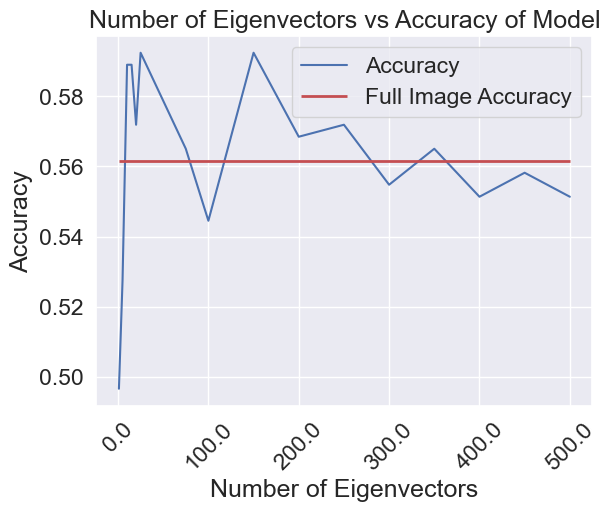

Wall time: 1min 29s


In [247]:
%%time
num_vectors = [1, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500]
accuracies, full_accuracy = train_by_eigenvectors(concat_imgs, labels, 0.2825, num_vectors, True, plot_accuracies=True, test_set=set_5050)

C:\Users\icedn\AppData\Local\Temp\ipykernel_16544\3932898215.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


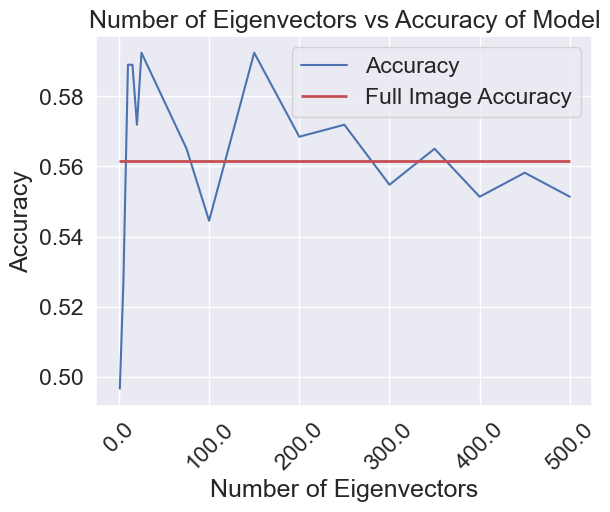

In [271]:
## Plot eigenvectors accuracy
fig, ax = plt.subplots()
ax.plot(num_vectors,accuracies, color='b', label='Accuracy')
ax.hlines(y=0.5616438356164384, xmin=0, xmax=500, linewidth=2, color='r', label='Full Image Accuracy')
ax.ticklabel_format(useOffset=False)
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_title("Number of Eigenvectors vs Accuracy of Model")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of Eigenvectors")
#ax.set_ylim(0, 1)
ax.legend()
plt.show()

Testing weight: 0.15
Accuracy of [0: 0.15, 1: 0.85] = 0.5102739726027398
Correct 0: 3, Correct 1: 146
False 0: 0, False 1: 143
Guessed positive at rate: 0.9897260273972602, Real rate: 0.5

Testing weight: 0.16
Accuracy of [0: 0.16, 1: 0.84] = 0.5136986301369864
Correct 0: 4, Correct 1: 146
False 0: 0, False 1: 142
Guessed positive at rate: 0.9863013698630136, Real rate: 0.5

Testing weight: 0.17
Accuracy of [0: 0.17, 1: 0.83] = 0.5205479452054794
Correct 0: 7, Correct 1: 145
False 0: 1, False 1: 139
Guessed positive at rate: 0.9726027397260274, Real rate: 0.5

Testing weight: 0.18000000000000002
Accuracy of [0: 0.18000000000000002, 1: 0.82] = 0.5273972602739726
Correct 0: 9, Correct 1: 145
False 0: 1, False 1: 137
Guessed positive at rate: 0.9657534246575342, Real rate: 0.5

Testing weight: 0.19000000000000003
Accuracy of [0: 0.19000000000000003, 1: 0.8099999999999999] = 0.5342465753424658
Correct 0: 12, Correct 1: 144
False 0: 2, False 1: 134
Guessed positive at rate: 0.95205479452054

C:\Users\icedn\AppData\Local\Temp\ipykernel_16544\433748209.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


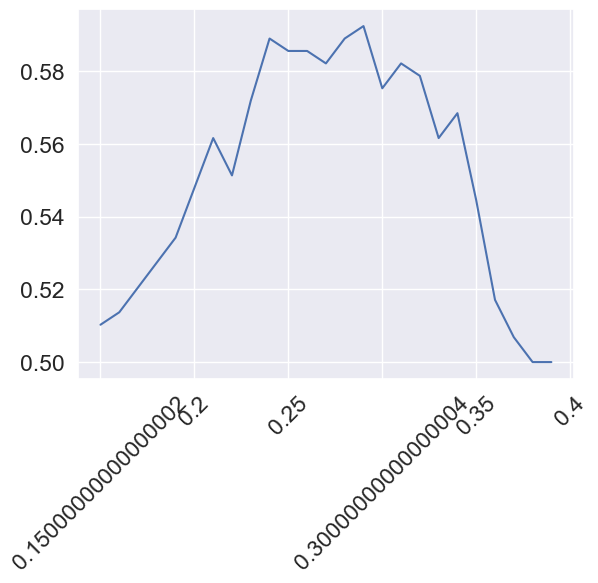

Wall time: 5.97 s


In [294]:
%%time
## Testing models across weights with 25 eigenvectors
inputs = reduce_dimensionality(concat_imgs.T, vectors, 25).T
accuracies_25, models_25 = test_weights(inputs[train_set], y_train, inputs[set_5050], labels[set_5050], np.arange(0.15, 0.4, 0.01), plot_accuracies=True)

In [288]:
%%time
## Get the predictions on the test set from the model trained above
predictions_25_5050 = get_predictions(inputs[set_5050], models_25)

Wall time: 1.12 s


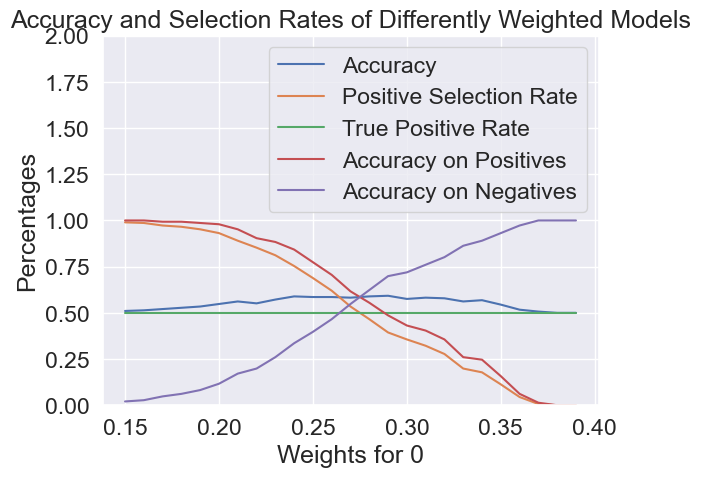

In [292]:
## Plot data from the models trained above
plot_rates(labels[set_5050], predictions_25_5050, np.arange(0.15, 0.4, 0.01), height=2)